In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Data preparation

In [2]:
customers = pd.read_csv("personio_customers.csv")
events = pd.read_csv("personio_events.csv")

In [3]:
customers["PURCHASE_DATE"] = pd.to_datetime(customers["PURCHASE_DATE"])
customers["PURCHASE_MONTH"] = customers["PURCHASE_DATE"].dt.to_period("M")
customers["COUNTRY_GROUP"] = customers["COUNTRY"].apply(
    lambda x: "DACH" if x in ["Germany", "Austria", "Switzerland"] else x
)
events["EVENT_DATE"] = pd.to_datetime(events["EVENT_DATE"])
events["EVENT_MONTH"] = events["EVENT_DATE"].dt.to_period("M")


In [4]:
customers.head()

,CUSTOMER_ID,COUNTRY,NO_EMPLOYEES,IS_STILL_CUSTOMER,PURCHASED_AS_NEW_CUSTOMER,INDUSTRY_CLUSTER,PURCHASE_DATE,PURCHASE_MONTH,COUNTRY_GROUP
0,019acc43b90db17385b4cc5e201635e4,UK,50.0,True,True,Deskless dominant,2023-01-01,2023-01,UK
1,0b50a0ea27a1076ea139fe271673d5a1,UK,100.0,True,True,Technical operators,2023-01-01,2023-01,UK
2,172f92934eae8bf32b31f4ad2609dc34,UK,50.0,True,True,Technical operators,2023-01-01,2023-01,UK
3,1e1430c902e49b2378830d0754303d4c,Austria,250.0,True,True,Digital desks,2023-01-01,2023-01,DACH
4,21a8ea62ecc6da2937e8c840e338c71d,UK,400.0,True,True,Technical operators,2023-01-01,2023-01,UK


In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   CUSTOMER_ID                1608 non-null   object        
 1   COUNTRY                    1608 non-null   object        
 2   NO_EMPLOYEES               1603 non-null   float64       
 3   IS_STILL_CUSTOMER          1608 non-null   bool          
 4   PURCHASED_AS_NEW_CUSTOMER  1608 non-null   bool          
 5   INDUSTRY_CLUSTER           1447 non-null   object        
 6   PURCHASE_DATE              1608 non-null   datetime64[ns]
 7   PURCHASE_MONTH             1608 non-null   period[M]     
 8   COUNTRY_GROUP              1608 non-null   object        
dtypes: bool(2), datetime64[ns](1), float64(1), object(4), period[M](1)
memory usage: 91.2+ KB


In [6]:
events.head()

,CUSTOMER_ID,EVENT,EVENT_DATE,EVENT_MONTH
0,19422b436106a1cbc45bbe12bc59d11a,FIRST_JOB_CREATION_COMPLETED_AT,2023-01-02,2023-01
1,19422b436106a1cbc45bbe12bc59d11a,FIRST_JOB_CREATION_STARTED_AT,2023-01-02,2023-01
2,1cd7eb965cc452673f979e173540d25a,FIRST_JOB_CREATION_STARTED_AT,2023-01-03,2023-01
3,1e1430c902e49b2378830d0754303d4c,FIRST_JOB_CREATION_STARTED_AT,2023-01-03,2023-01
4,4b70b8e8906ca1f818c6a8a87fcddb45,FIRST_JOB_CREATION_STARTED_AT,2023-01-04,2023-01


In [7]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794 entries, 0 to 1793
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CUSTOMER_ID  1794 non-null   object        
 1   EVENT        1794 non-null   object        
 2   EVENT_DATE   1794 non-null   datetime64[ns]
 3   EVENT_MONTH  1794 non-null   period[M]     
dtypes: datetime64[ns](1), object(2), period[M](1)
memory usage: 56.2+ KB


# Customers EDA

In [8]:
# check for duplicates
customers["CUSTOMER_ID"].nunique() == len(customers)

True

In [9]:
customers.head()

,CUSTOMER_ID,COUNTRY,NO_EMPLOYEES,IS_STILL_CUSTOMER,PURCHASED_AS_NEW_CUSTOMER,INDUSTRY_CLUSTER,PURCHASE_DATE,PURCHASE_MONTH,COUNTRY_GROUP
0,019acc43b90db17385b4cc5e201635e4,UK,50.0,True,True,Deskless dominant,2023-01-01,2023-01,UK
1,0b50a0ea27a1076ea139fe271673d5a1,UK,100.0,True,True,Technical operators,2023-01-01,2023-01,UK
2,172f92934eae8bf32b31f4ad2609dc34,UK,50.0,True,True,Technical operators,2023-01-01,2023-01,UK
3,1e1430c902e49b2378830d0754303d4c,Austria,250.0,True,True,Digital desks,2023-01-01,2023-01,DACH
4,21a8ea62ecc6da2937e8c840e338c71d,UK,400.0,True,True,Technical operators,2023-01-01,2023-01,UK


In [92]:
cust_country_active = (
    customers[["COUNTRY", "IS_STILL_CUSTOMER"]]
    .groupby(["COUNTRY"])
    .value_counts(normalize=True)
).reset_index()
cust_country_active = pd.merge(
    cust_country_active[cust_country_active.IS_STILL_CUSTOMER == True][
        ["COUNTRY", "proportion"]
    ],
    cust_country,
    on="COUNTRY",
    how="outer",
)
cust_country_active["proportion"] = round(
    100 * cust_country_active["proportion"].fillna(0), 2
)
cust_country_active["count"] = cust_country_active["count"].fillna(0)
cust_country_active = cust_country_active.rename(
    columns={"proportion": "proportion_active", "count": "count_total"}
)

cust_country_active.sort_values(by="count_total", ascending=True, inplace=True)

cust_country_active

,COUNTRY,proportion_active,count_total
14,Kosovo,100.00,1
11,India,100.00,1
18,North Macedonia,100.00,1
2,Canada,100.00,2
10,Hungary,100.00,2
15,Lithuania,100.00,2
7,Finland,100.00,2
4,Croatia,100.00,2
20,Portugal,100.00,2
19,Poland,100.00,2


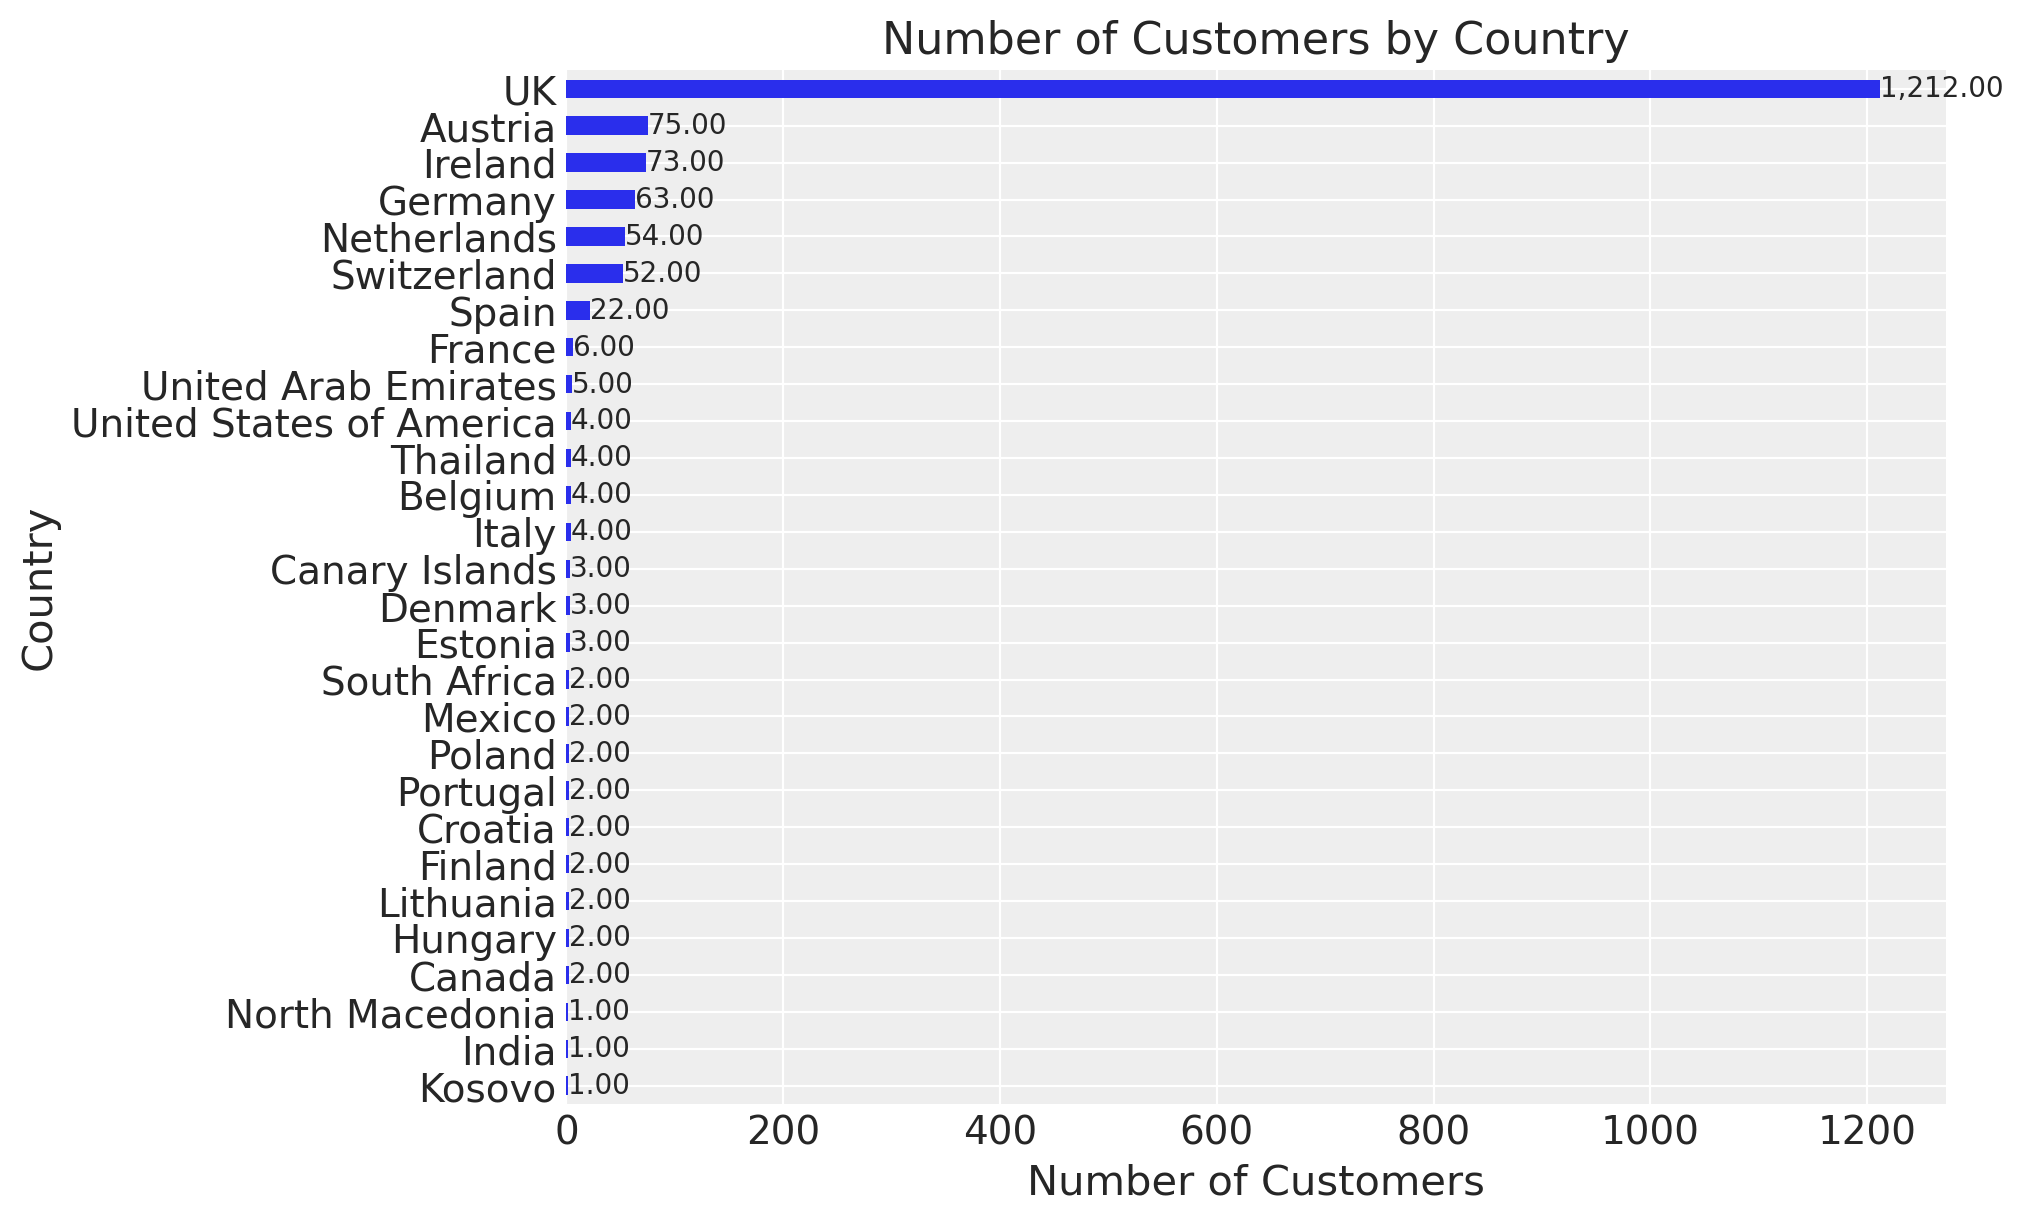

In [94]:
# Set COUNTRY as index for proper horizontal bar plotting
plot_data = cust_country_active.set_index("COUNTRY")

# Create the plot
ax_cc = plot_data["count_total"].plot.barh()
ax_cc.bar_label(ax_cc.containers[0], label_type="edge", fmt="{:,.2f}")
ax_cc.set_title("Number of Customers by Country")
ax_cc.set_xlabel("Number of Customers")
ax_cc.set_ylabel("Country")
plt.show()

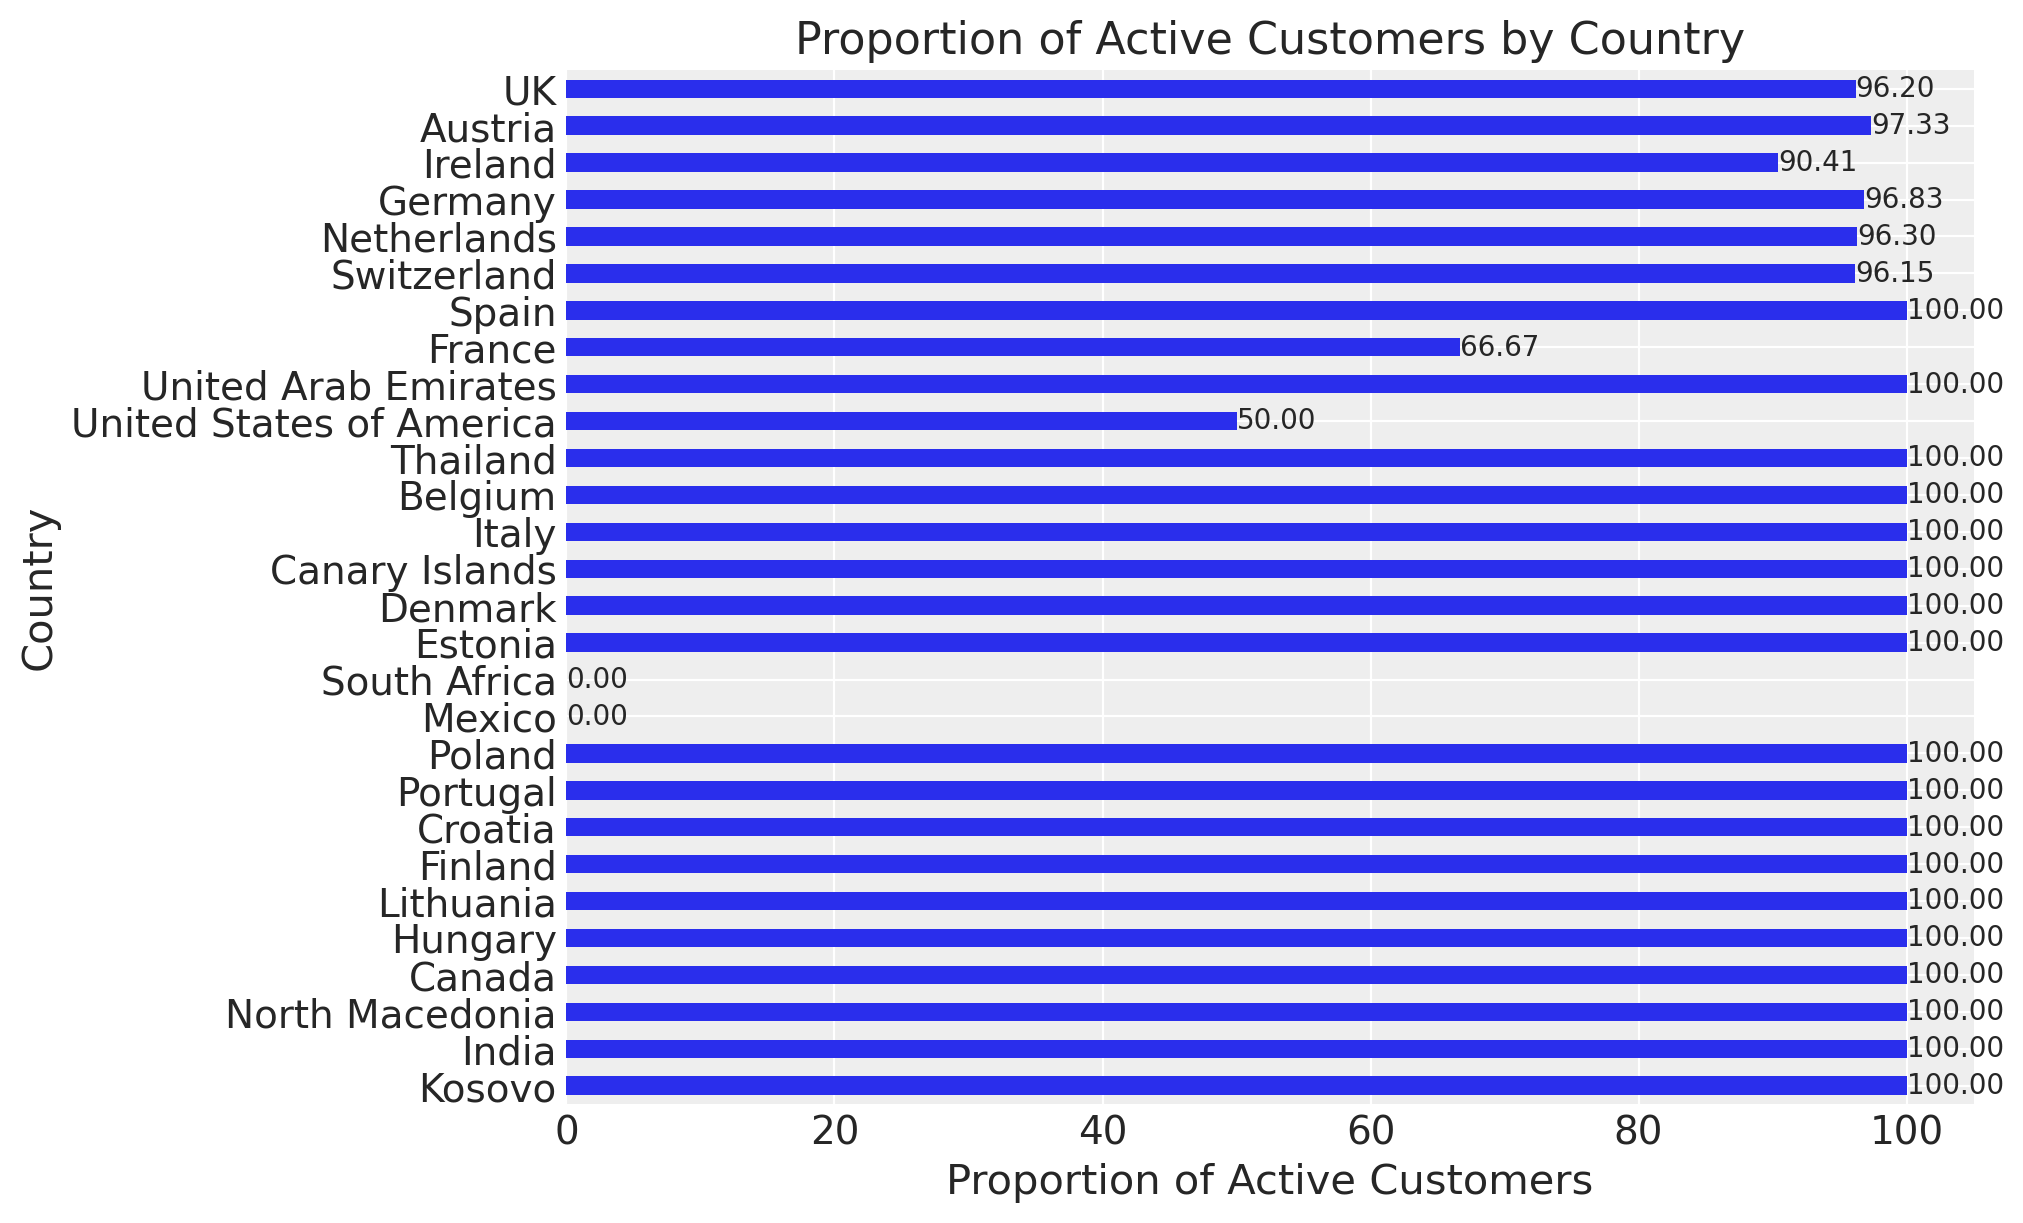

In [96]:
# Create the plot
ax_cc = plot_data["proportion_active"].plot.barh()
ax_cc.bar_label(ax_cc.containers[0], label_type="edge", fmt="{:,.2f}")
ax_cc.set_title("Proportion of Active Customers by Country")
ax_cc.set_xlabel("Proportion of Active Customers")
ax_cc.set_ylabel("Country")
plt.show()

In [98]:
customers[["COUNTRY", "IS_STILL_CUSTOMER"]].groupby(["COUNTRY"]).value_counts(
    normalize=False
).reset_index()

,COUNTRY,IS_STILL_CUSTOMER,count
0,Austria,True,73
1,Austria,False,2
2,Belgium,True,4
3,Canada,True,2
4,Canary Islands,True,3
5,Croatia,True,2
6,Denmark,True,3
7,Estonia,True,3
8,Finland,True,2
9,France,True,4


In [ ]:
# personal check: are most of the missed customers new customers?
missed_cust_check = (
    customers[["COUNTRY", "IS_STILL_CUSTOMER", "PURCHASED_AS_NEW_CUSTOMER"]]
    .groupby(["COUNTRY"])
    .value_counts(normalize=False)
    .reset_index()
)
missed_cust_check[missed_cust_check.IS_STILL_CUSTOMER == False]

,COUNTRY,IS_STILL_CUSTOMER,PURCHASED_AS_NEW_CUSTOMER,count
2,Austria,False,True,2
12,France,False,True,2
15,Germany,False,True,2
20,Ireland,False,True,7
25,Mexico,False,False,2
28,Netherlands,False,True,2
32,South Africa,False,True,2
37,Switzerland,False,True,2
42,UK,False,True,39
43,UK,False,False,7


In [148]:
countries_to_include = [
    "Switzerland",
    "Netherlands",
    "Germany",
    "Ireland",
    "Austria",
    "UK",
]
customers_filtered = customers[customers["COUNTRY"].isin(countries_to_include)]

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_2048/2634088712.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(data_by_country, labels=countries, patch_artist=True)
/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_2048/2634088712.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


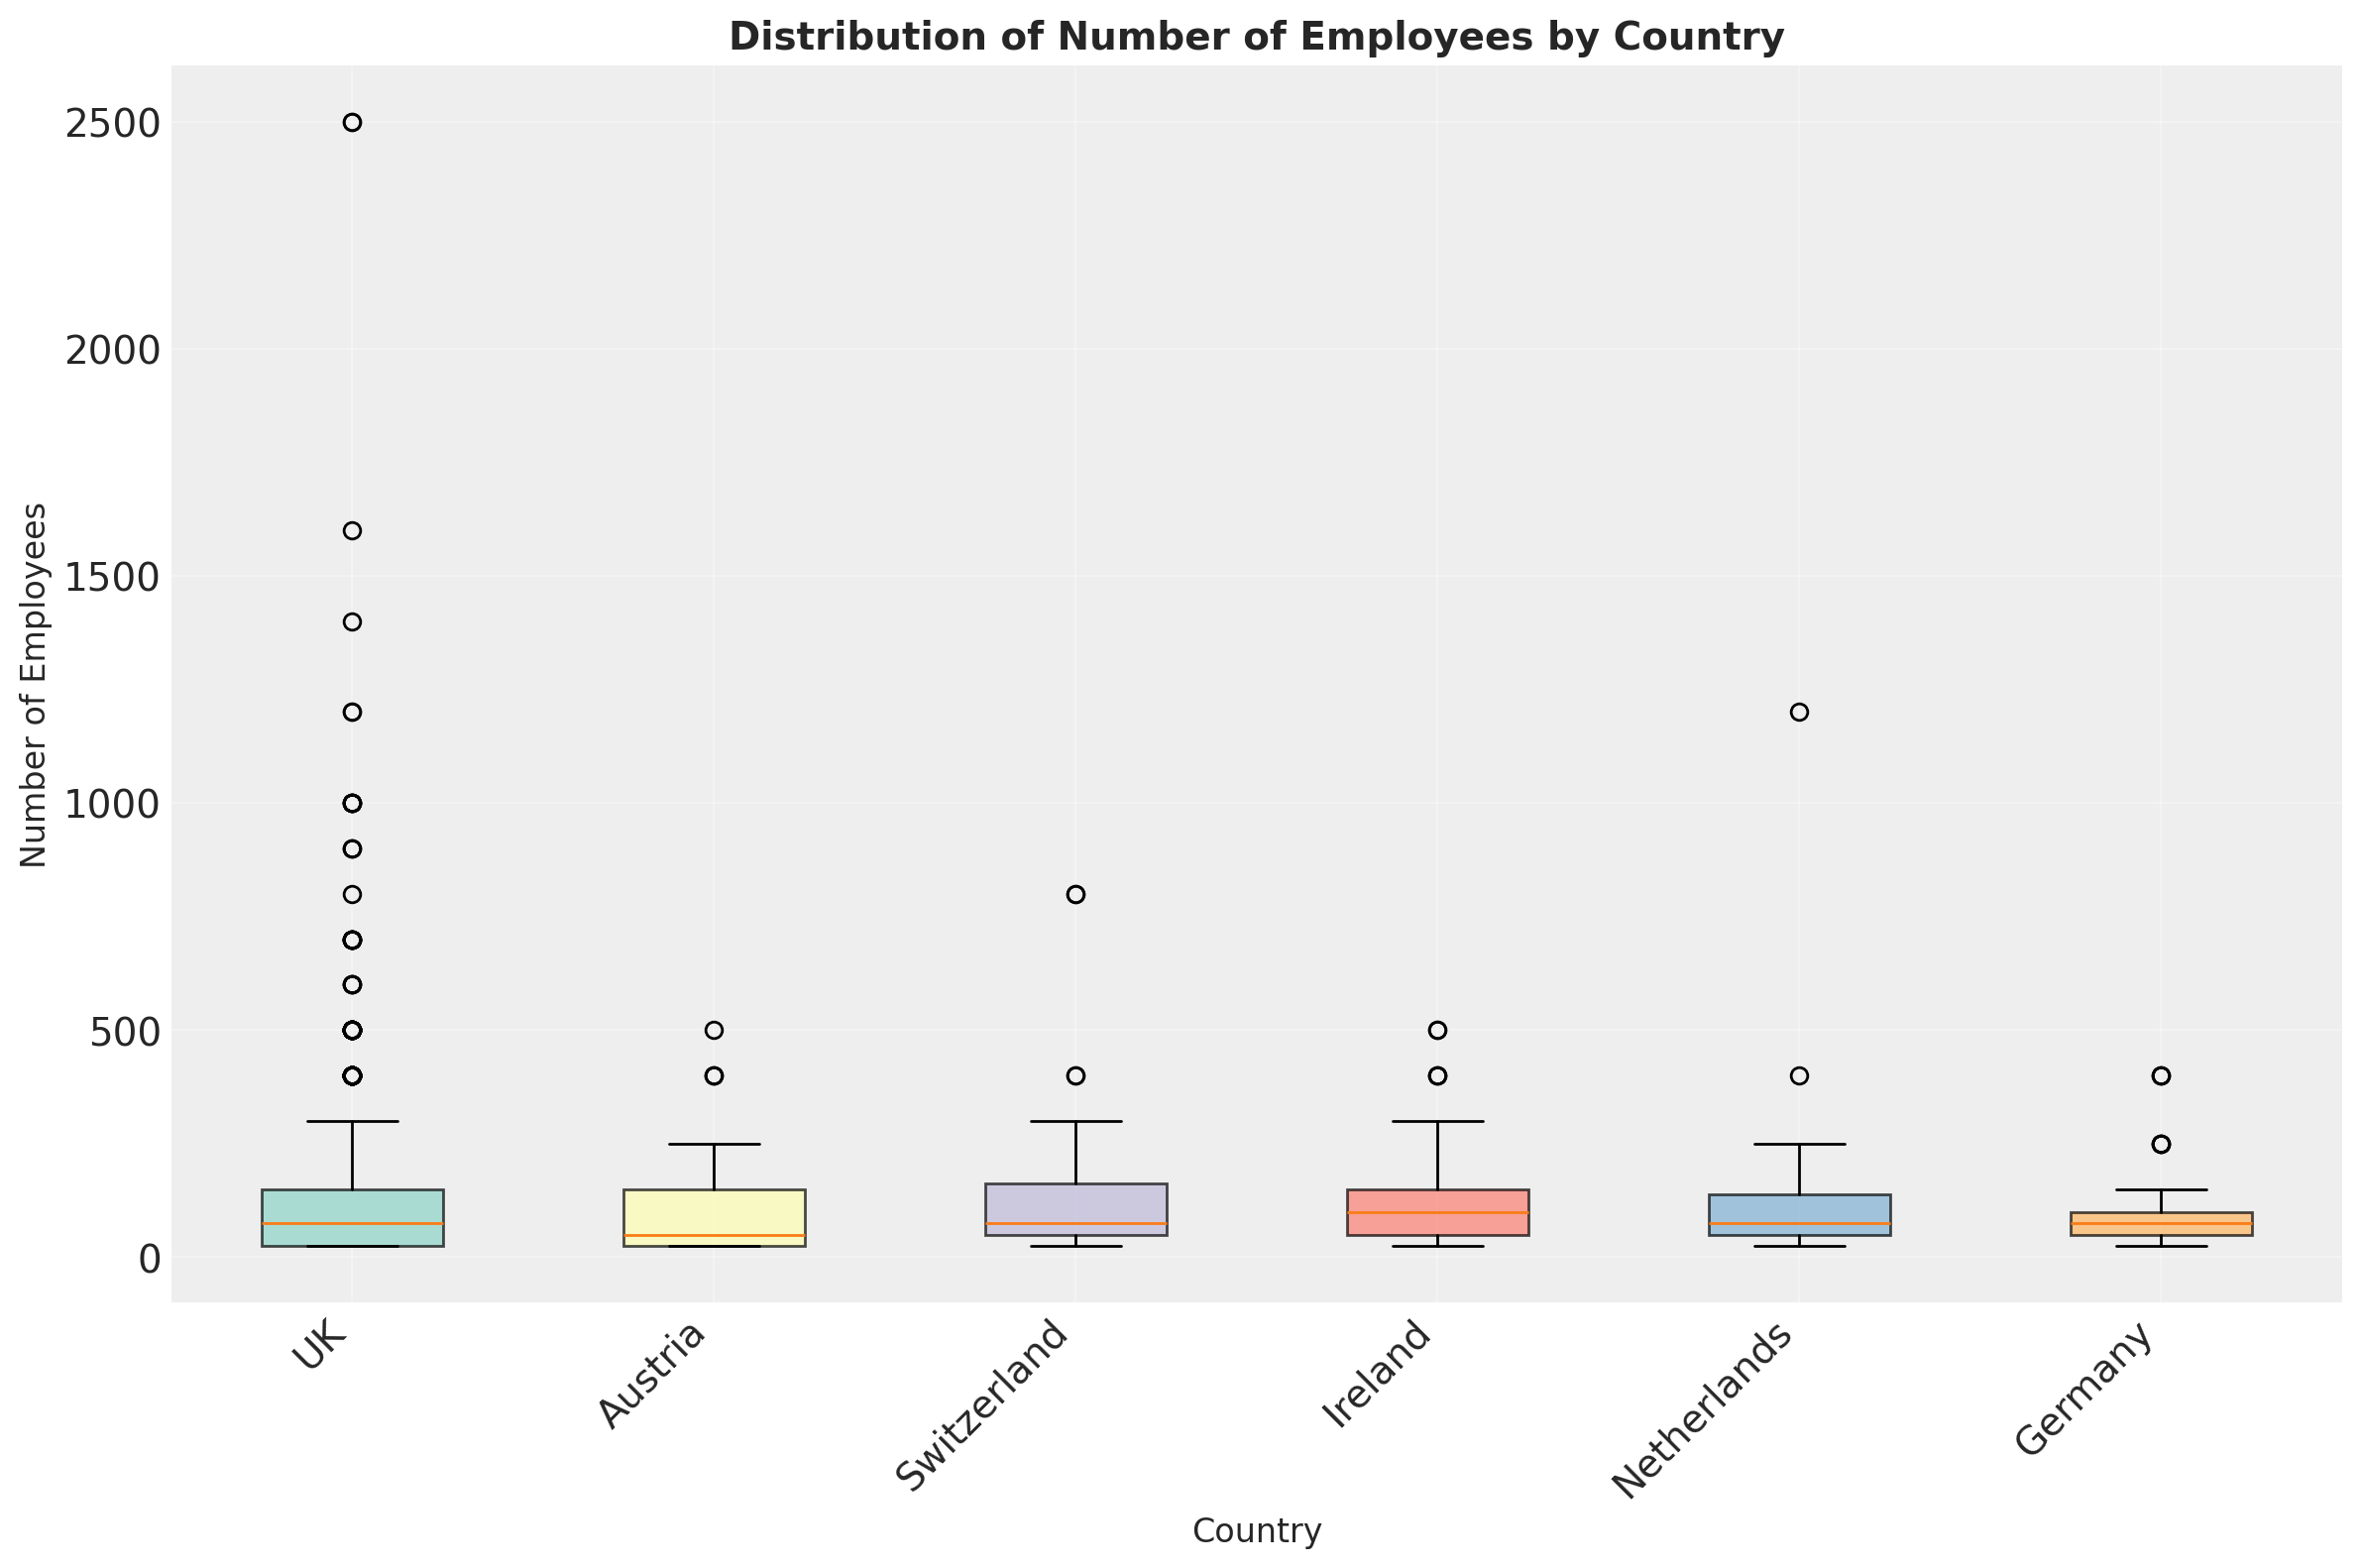

In [ ]:
# Boxplot of NO_EMPLOYEES by COUNTRY
plt.figure(figsize=(12, 8))

# Get unique countries and prepare data for boxplot
countries = customers["COUNTRY"].unique()
data_by_country = []

for country in countries:
    country_data = customers_filtered[customers_filtered["COUNTRY"] == country][
        "NO_EMPLOYEES"
    ].dropna()
    data_by_country.append(country_data)

# Create the boxplot
box_plot = plt.boxplot(data_by_country, labels=countries, patch_artist=True)

# Customize the plot
plt.title(
    "Distribution of Number of Employees by Country", fontsize=14, fontweight="bold"
)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Employees", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add some color to the boxes
colors = plt.cm.Set3(range(len(countries)))
for patch, color in zip(box_plot["boxes"], colors, strict=False):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_2048/4192790281.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


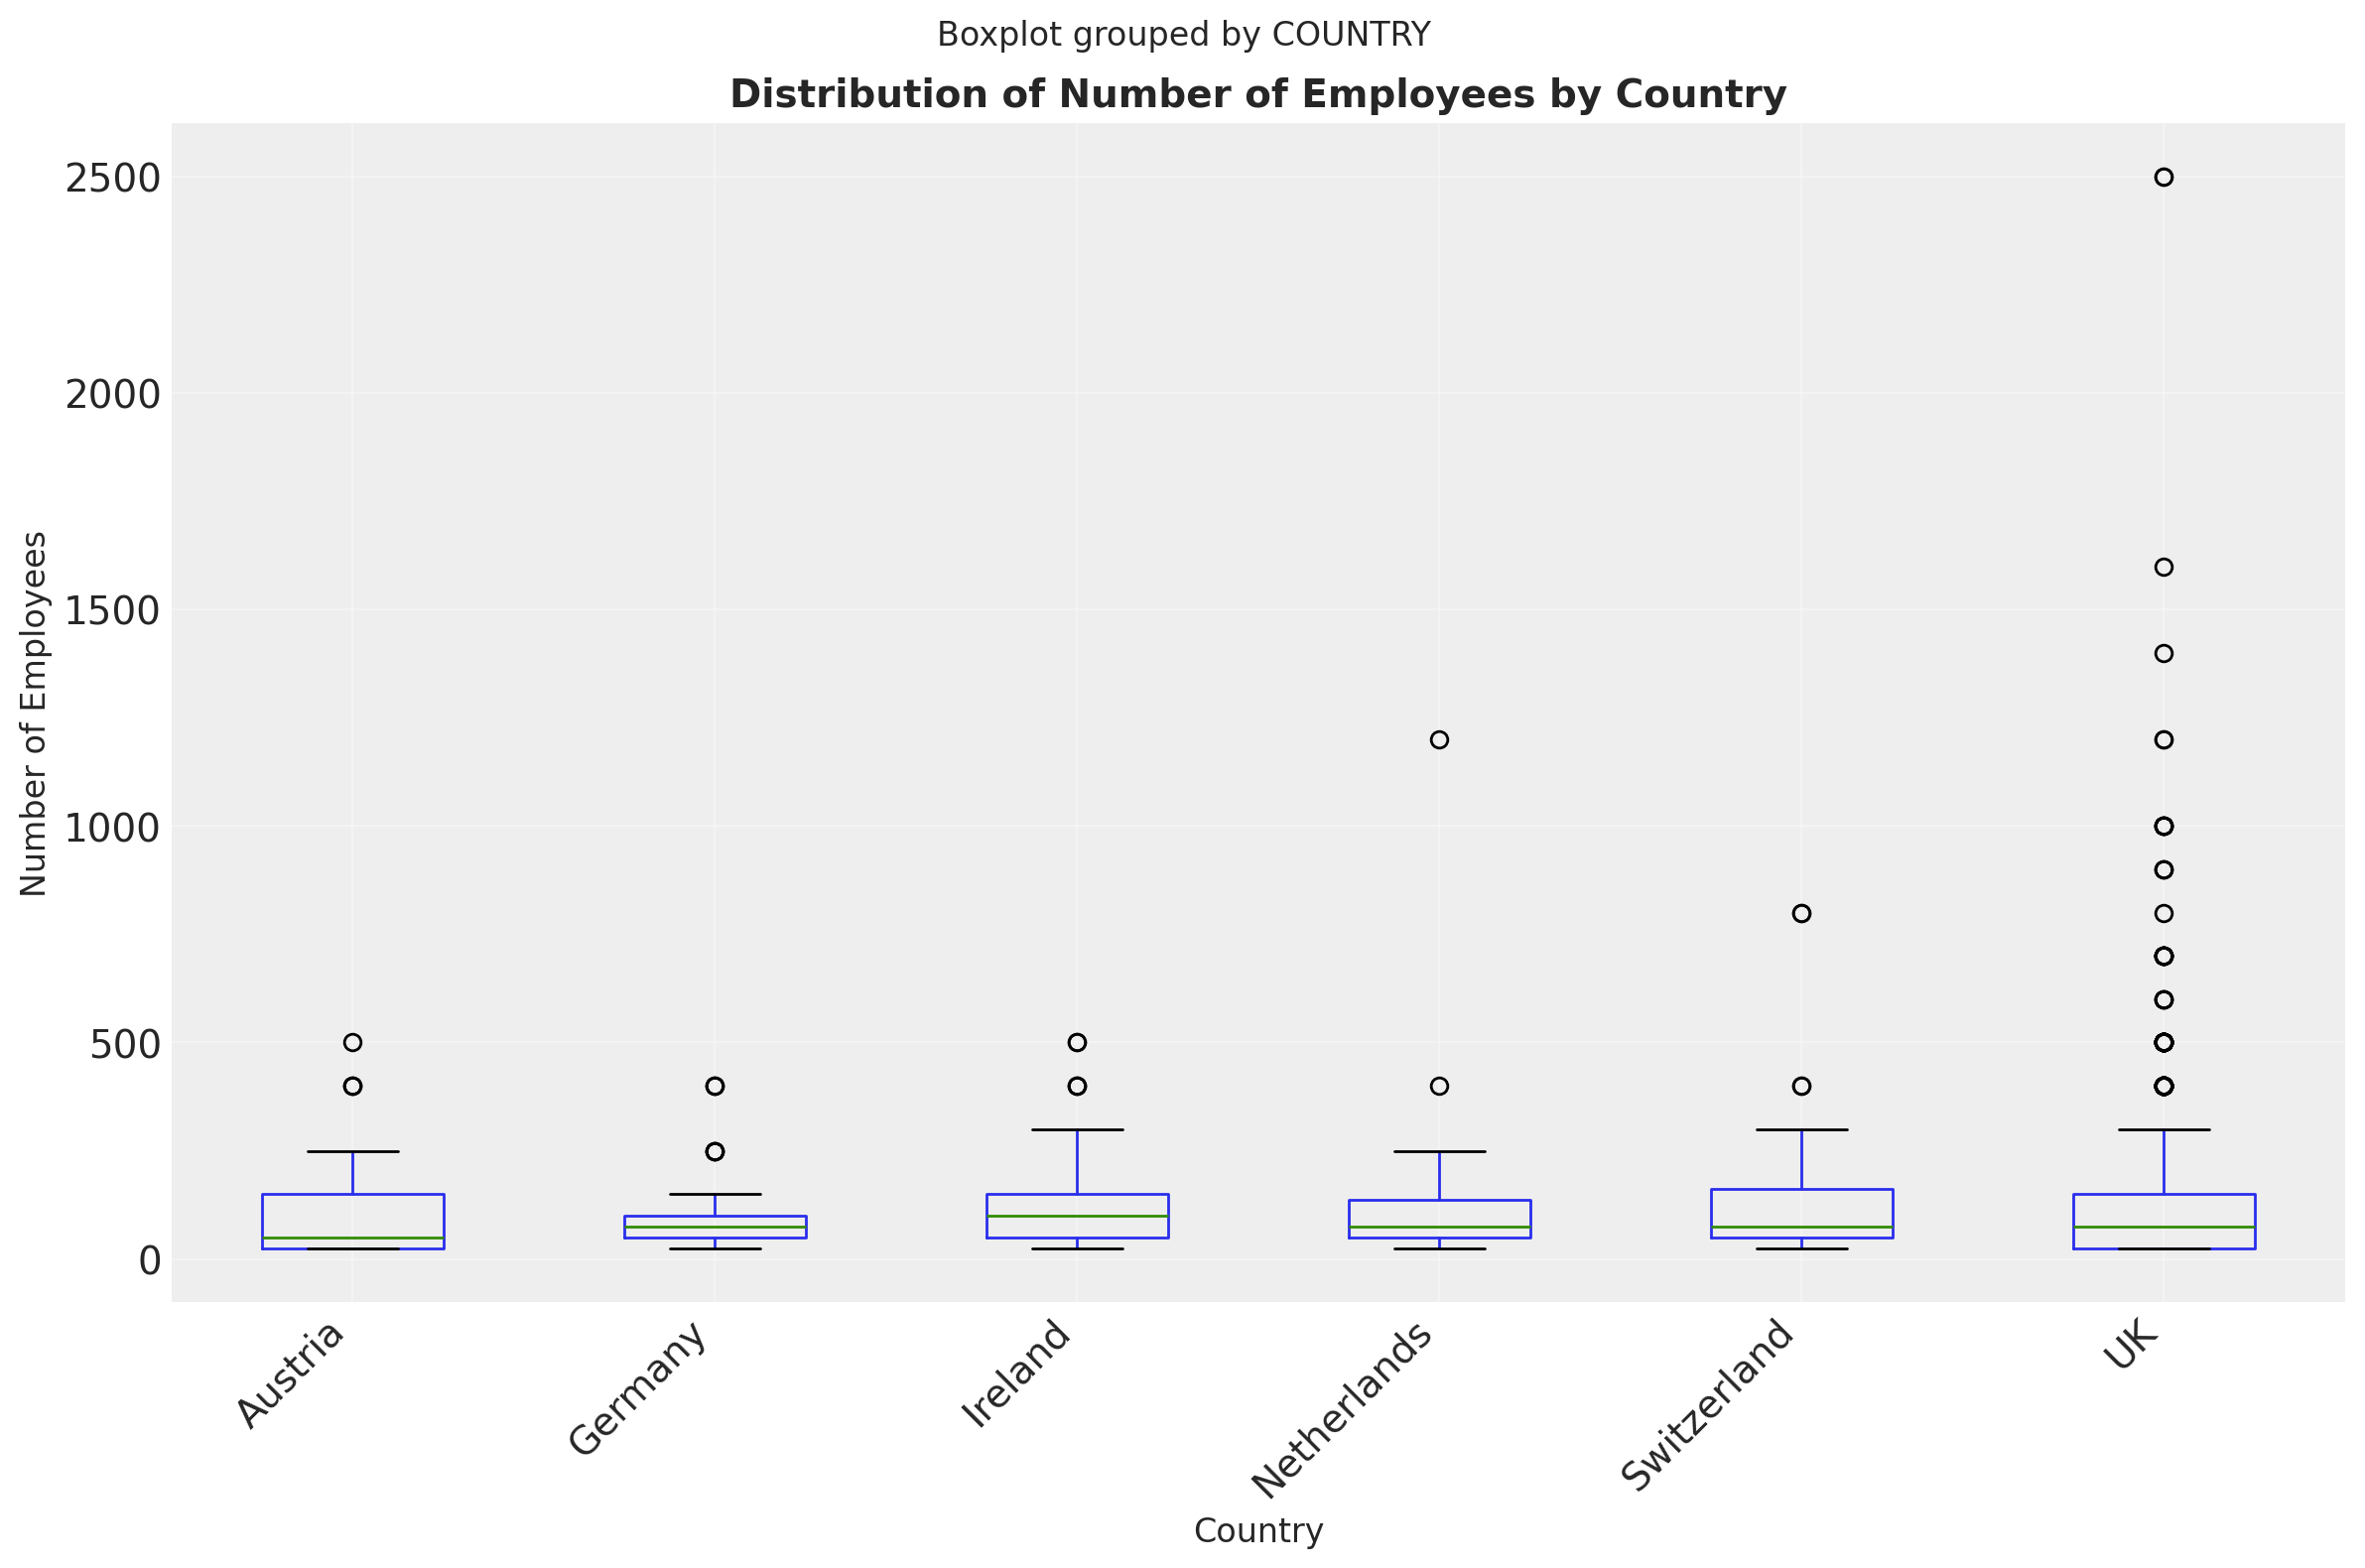

In [150]:
# Alternative approach using pandas boxplot (simpler)
plt.figure(figsize=(12, 8))
customers_filtered.boxplot(column="NO_EMPLOYEES", by="COUNTRY", ax=plt.gca())
plt.title(
    "Distribution of Number of Employees by Country", fontsize=14, fontweight="bold"
)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Employees", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [152]:
# Summary statistics
print("Summary Statistics for NO_EMPLOYEES:")
print("=" * 40)
print(f"Count: {customers_filtered['NO_EMPLOYEES'].count()}")
print(f"Mean: {customers_filtered['NO_EMPLOYEES'].mean():.2f}")
print(f"Median: {customers_filtered['NO_EMPLOYEES'].median():.2f}")
print(f"Std: {customers_filtered['NO_EMPLOYEES'].std():.2f}")
print(f"Min: {customers_filtered['NO_EMPLOYEES'].min():.2f}")
print(f"Max: {customers_filtered['NO_EMPLOYEES'].max():.2f}")
print(f"25th percentile: {customers_filtered['NO_EMPLOYEES'].quantile(0.25):.2f}")
print(f"75th percentile: {customers_filtered['NO_EMPLOYEES'].quantile(0.75):.2f}")

# Additional insights
print("\nAdditional Insights:")
print("=" * 40)
print(
    f"Companies with < 10 employees: {(customers_filtered['NO_EMPLOYEES'] < 10).sum()} ({(customers_filtered['NO_EMPLOYEES'] < 10).mean() * 100:.1f}%)"
)
print(
    f"Companies with 10-50 employees: {((customers_filtered['NO_EMPLOYEES'] >= 10) & (customers_filtered['NO_EMPLOYEES'] < 50)).sum()} ({((customers_filtered['NO_EMPLOYEES'] >= 10) & (customers_filtered['NO_EMPLOYEES'] < 50)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 50-200 employees: {((customers_filtered['NO_EMPLOYEES'] >= 50) & (customers_filtered['NO_EMPLOYEES'] < 200)).sum()} ({((customers_filtered['NO_EMPLOYEES'] >= 50) & (customers_filtered['NO_EMPLOYEES'] < 200)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 200-500 employees: {((customers_filtered['NO_EMPLOYEES'] >= 200) & (customers_filtered['NO_EMPLOYEES'] < 500)).sum()} ({((customers_filtered['NO_EMPLOYEES'] >= 200) & (customers_filtered['NO_EMPLOYEES'] < 500)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 500+ employees: {(customers_filtered['NO_EMPLOYEES'] >= 500).sum()} ({(customers_filtered['NO_EMPLOYEES'] >= 500).mean() * 100:.1f}%)"
)


Summary Statistics for NO_EMPLOYEES:
Count: 1526
Mean: 122.97
Median: 75.00
Std: 174.93
Min: 25.00
Max: 2500.00
25th percentile: 25.00
75th percentile: 150.00

Additional Insights:
Companies with < 10 employees: 0 (0.0%)
Companies with 10-50 employees: 417 (27.3%)
Companies with 50-200 employees: 814 (53.2%)
Companies with 200-500 employees: 238 (15.6%)
Companies with 500+ employees: 57 (3.7%)


In [ ]:
# Summary statistics
# (check if the distributions agree with the filtered dataset)
print("Summary Statistics for NO_EMPLOYEES:")
print("=" * 40)
print(f"Count: {customers['NO_EMPLOYEES'].count()}")
print(f"Mean: {customers['NO_EMPLOYEES'].mean():.2f}")
print(f"Median: {customers['NO_EMPLOYEES'].median():.2f}")
print(f"Std: {customers['NO_EMPLOYEES'].std():.2f}")
print(f"Min: {customers['NO_EMPLOYEES'].min():.2f}")
print(f"Max: {customers['NO_EMPLOYEES'].max():.2f}")
print(f"25th percentile: {customers['NO_EMPLOYEES'].quantile(0.25):.2f}")
print(f"75th percentile: {customers['NO_EMPLOYEES'].quantile(0.75):.2f}")

# Additional insights
print("\nAdditional Insights:")
print("=" * 40)
print(
    f"Companies with < 10 employees: {(customers['NO_EMPLOYEES'] < 10).sum()} ({(customers['NO_EMPLOYEES'] < 10).mean() * 100:.1f}%)"
)
print(
    f"Companies with 10-50 employees: {((customers['NO_EMPLOYEES'] >= 10) & (customers['NO_EMPLOYEES'] < 50)).sum()} ({((customers['NO_EMPLOYEES'] >= 10) & (customers['NO_EMPLOYEES'] < 50)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 50-200 employees: {((customers['NO_EMPLOYEES'] >= 50) & (customers['NO_EMPLOYEES'] < 200)).sum()} ({((customers['NO_EMPLOYEES'] >= 50) & (customers['NO_EMPLOYEES'] < 200)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 200-500 employees: {((customers['NO_EMPLOYEES'] >= 200) & (customers['NO_EMPLOYEES'] < 500)).sum()} ({((customers['NO_EMPLOYEES'] >= 200) & (customers['NO_EMPLOYEES'] < 500)).mean() * 100:.1f}%)"
)
print(
    f"Companies with 500+ employees: {(customers['NO_EMPLOYEES'] >= 500).sum()} ({(customers['NO_EMPLOYEES'] >= 500).mean() * 100:.1f}%)"
)


Summary Statistics for NO_EMPLOYEES:
Count: 1603
Mean: 122.45
Median: 75.00
Std: 174.13
Min: 25.00
Max: 2500.00
25th percentile: 25.00
75th percentile: 150.00

Additional Insights:
Companies with < 10 employees: 0 (0.0%)
Companies with 10-50 employees: 432 (26.9%)
Companies with 50-200 employees: 868 (54.0%)
Companies with 200-500 employees: 244 (15.2%)
Companies with 500+ employees: 59 (3.7%)


<Axes: >

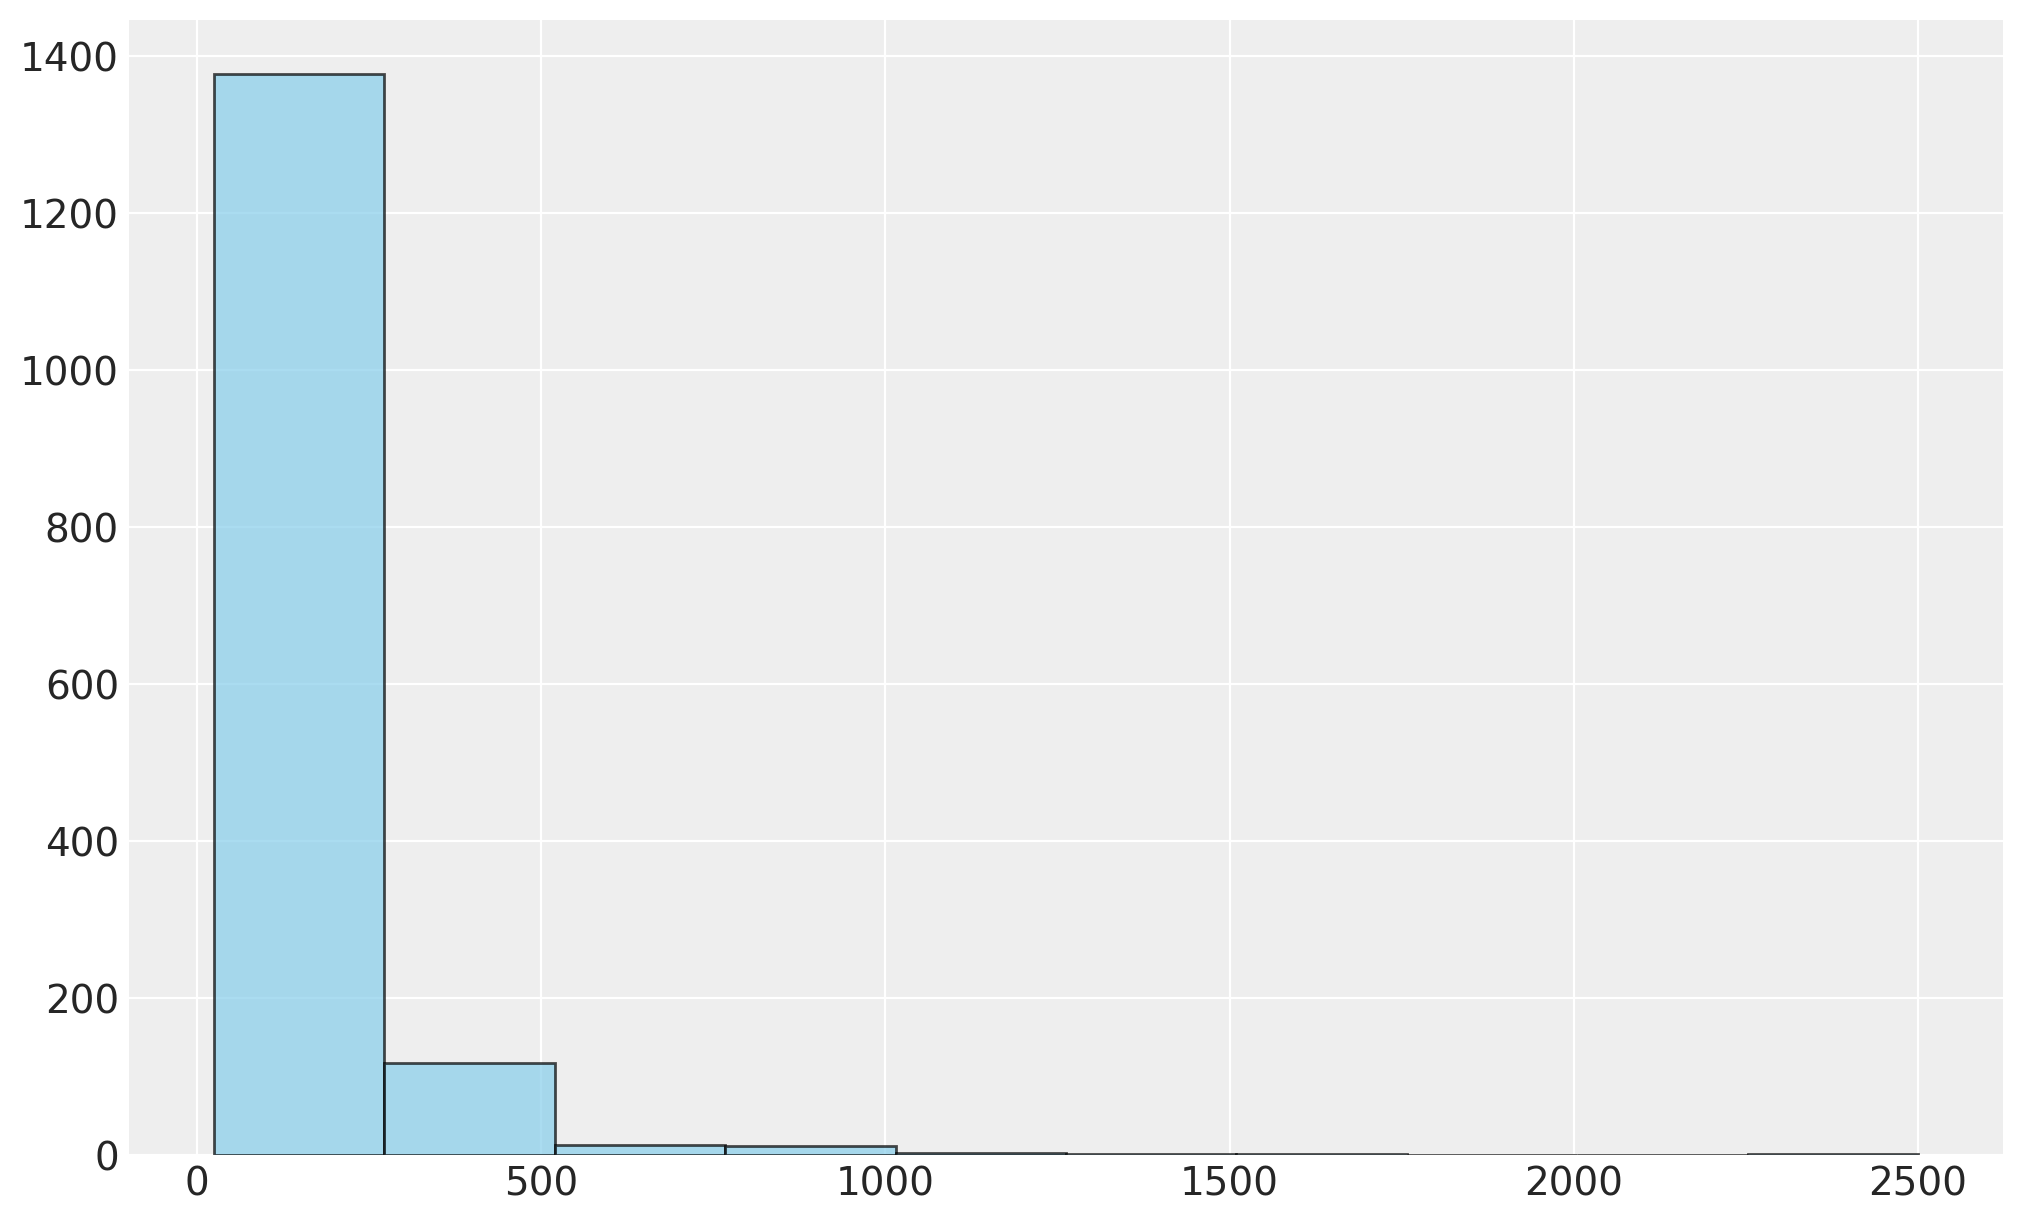

In [153]:
customers_filtered.loc[customers_filtered["NO_EMPLOYEES"] < 3000, "NO_EMPLOYEES"].hist(
    bins=10, alpha=0.7, color="skyblue", edgecolor="black"
)
# plt.show()

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_2048/2842560723.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


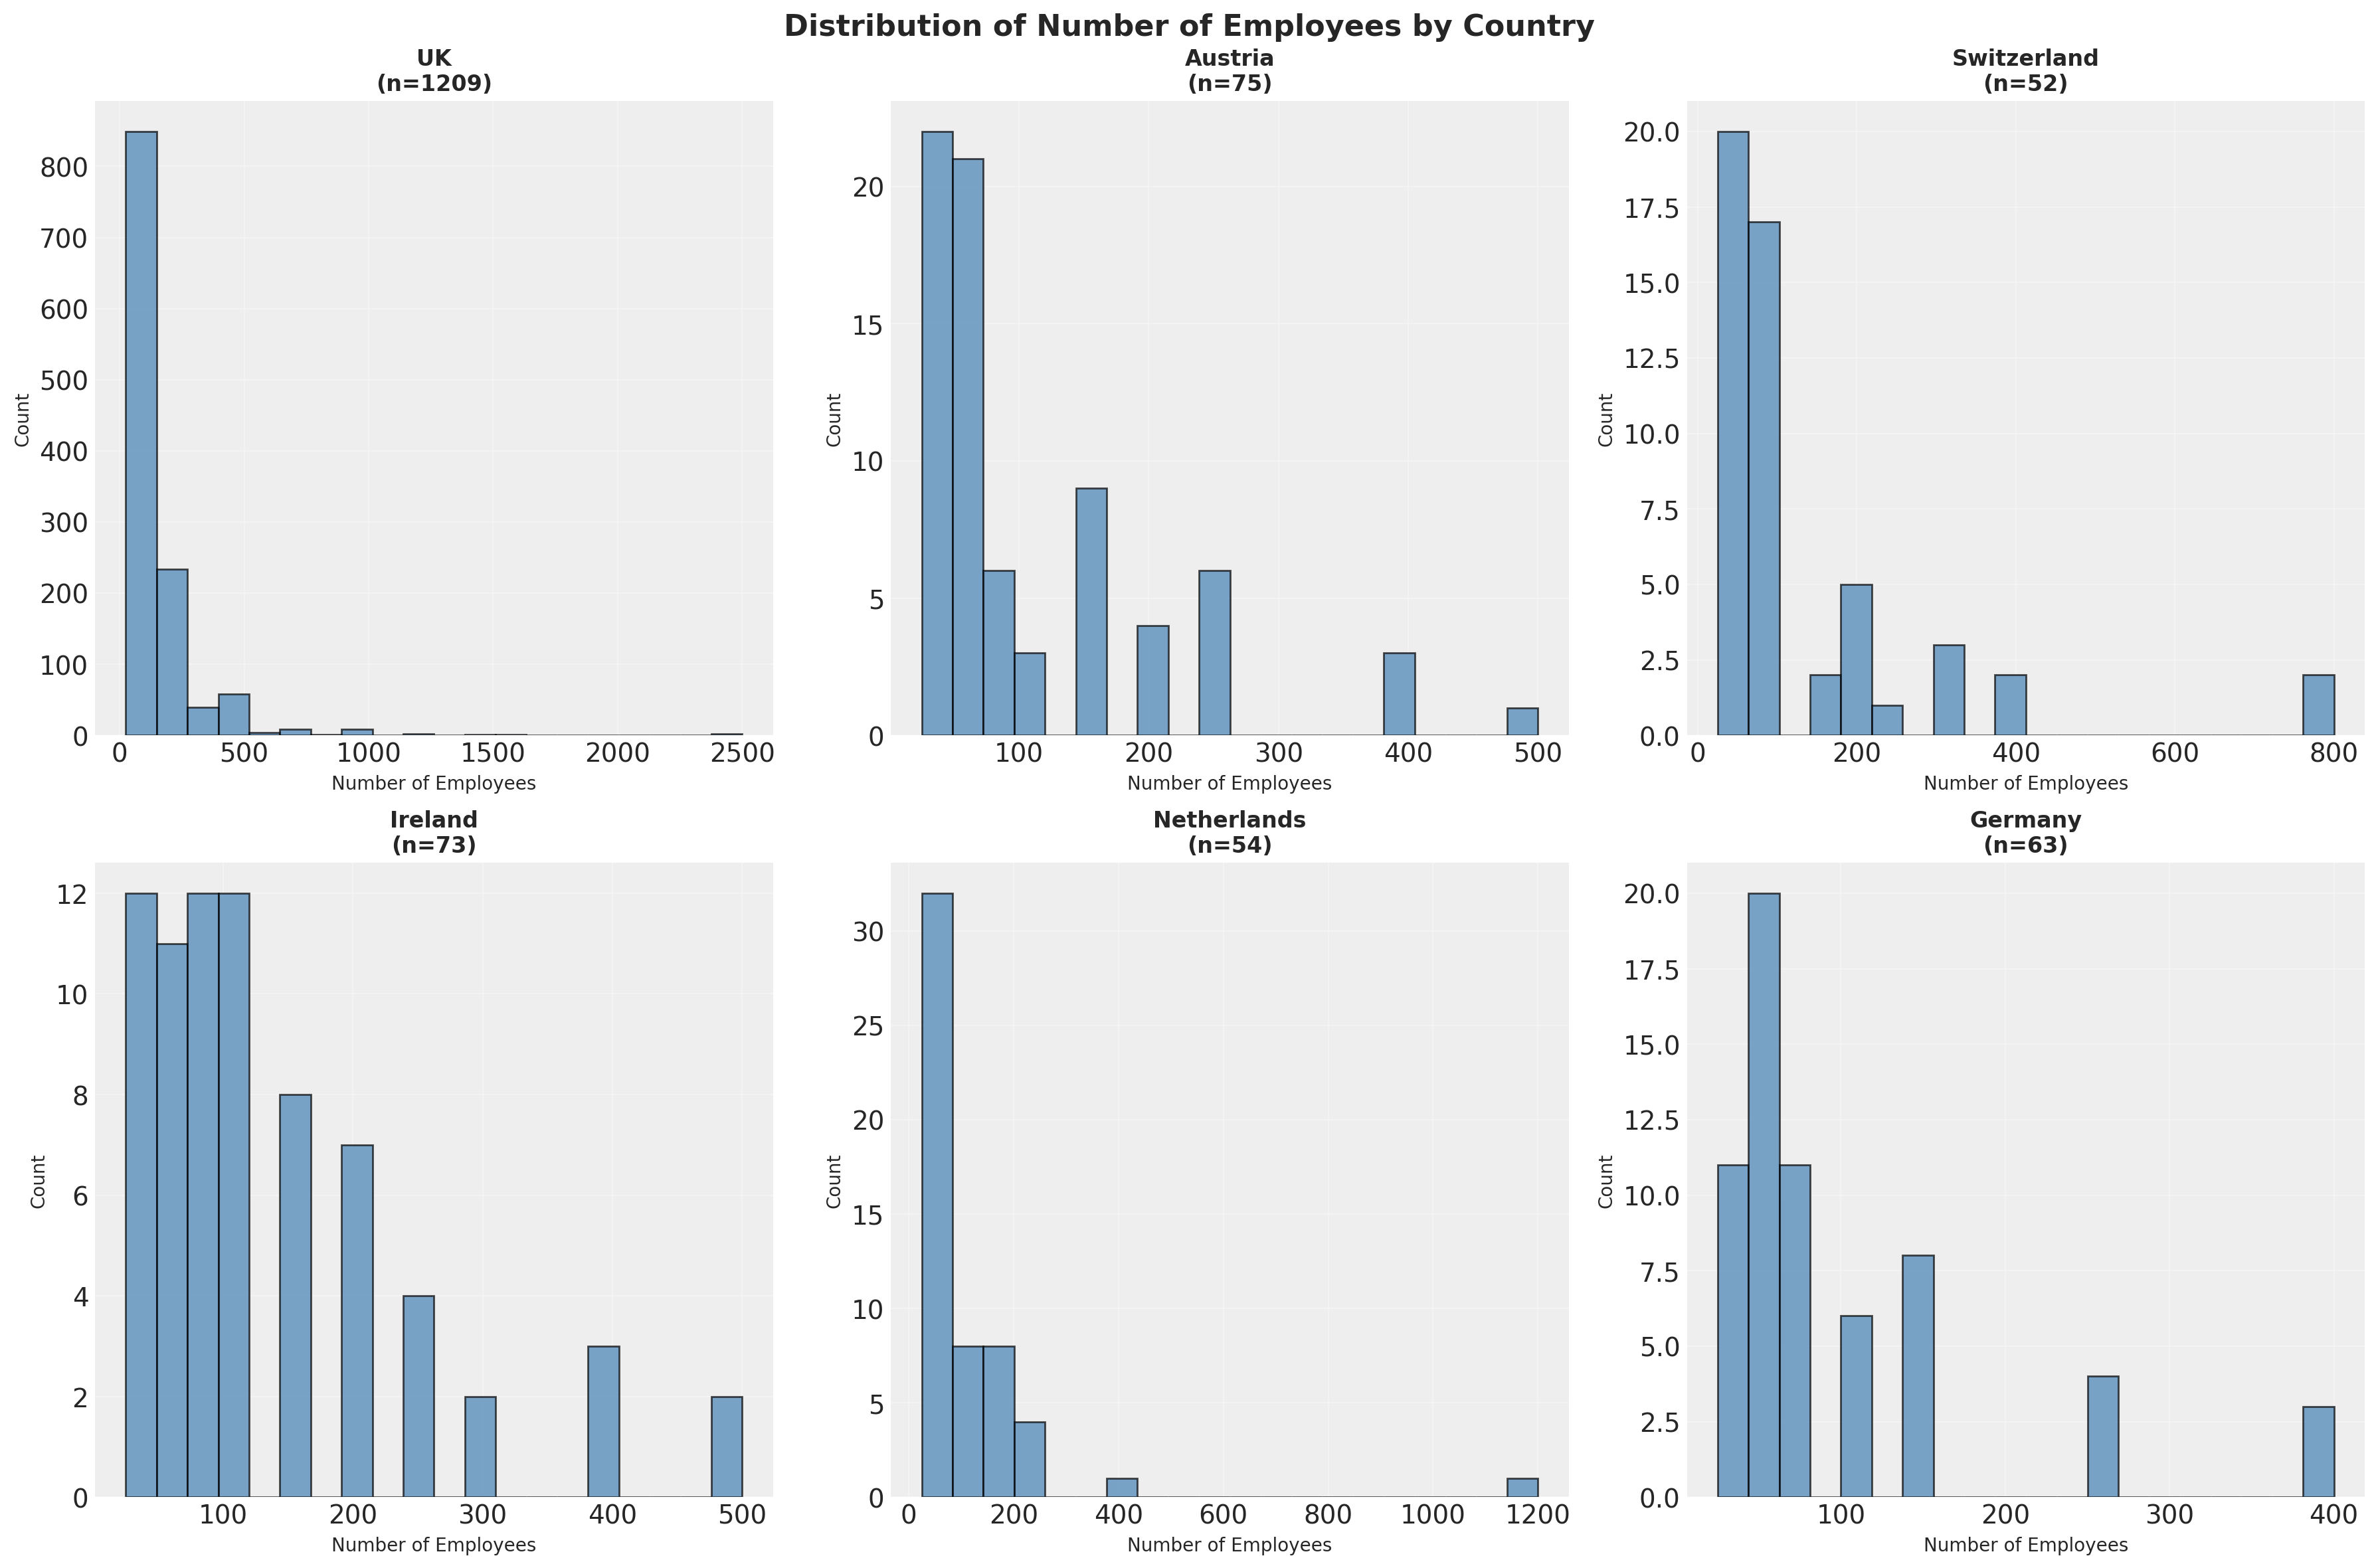

Summary Statistics by Country:

UK (n=1209):
  Mean: 125.0
  Median: 75.0
  Min: 25.0
  Max: 2500.0
  25th percentile: 25.00
  75th percentile: 150.00

Austria (n=75):
  Mean: 102.7
  Median: 50.0
  Min: 25.0
  Max: 500.0
  25th percentile: 25.00
  75th percentile: 150.00

Switzerland (n=52):
  Mean: 135.1
  Median: 75.0
  Min: 25.0
  Max: 800.0
  25th percentile: 50.00
  75th percentile: 162.50

Ireland (n=73):
  Mean: 128.1
  Median: 100.0
  Min: 25.0
  Max: 500.0
  25th percentile: 50.00
  75th percentile: 150.00

Netherlands (n=54):
  Mean: 118.5
  Median: 75.0
  Min: 25.0
  Max: 1200.0
  25th percentile: 50.00
  75th percentile: 137.50

Germany (n=63):
  Mean: 96.8
  Median: 75.0
  Min: 25.0
  Max: 400.0
  25th percentile: 50.00
  75th percentile: 100.00


In [156]:
# Distribution of NO_EMPLOYEES by Country
countries = customers_filtered["COUNTRY"].unique()
n_countries = len(countries)

# Calculate subplot layout
n_cols = 3
n_rows = (n_countries + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
fig.suptitle(
    "Distribution of Number of Employees by Country", fontsize=16, fontweight="bold"
)

# Flatten axes array for easier indexing
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

for i, country in enumerate(countries):
    ax = axes_flat[i]

    # Get data for this country
    country_data = customers_filtered[customers_filtered["COUNTRY"] == country][
        "NO_EMPLOYEES"
    ].dropna()

    # Create histogram
    country_data.hist(bins=20, ax=ax, alpha=0.7, color="steelblue", edgecolor="black")

    # Customize subplot
    ax.set_title(f"{country}\n(n={len(country_data)})", fontsize=12, fontweight="bold")
    ax.set_xlabel("Number of Employees", fontsize=10)
    ax.set_ylabel("Count", fontsize=10)
    ax.grid(True, alpha=0.3)

# Hide empty subplots
for i in range(n_countries, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

# Summary statistics by country
print("Summary Statistics by Country:")
print("=" * 50)
for country in countries:
    country_data = customers_filtered[customers_filtered["COUNTRY"] == country][
        "NO_EMPLOYEES"
    ].dropna()
    print(f"\n{country} (n={len(country_data)}):")
    print(f"  Mean: {country_data.mean():.1f}")
    print(f"  Median: {country_data.median():.1f}")
    print(f"  Min: {country_data.min():.1f}")
    print(f"  Max: {country_data.max():.1f}")
    print(f"  25th percentile: {country_data.quantile(0.25):.2f}")
    print(f"  75th percentile: {country_data.quantile(0.75):.2f}")


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_2048/1822575149.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1400x1000 with 0 Axes>

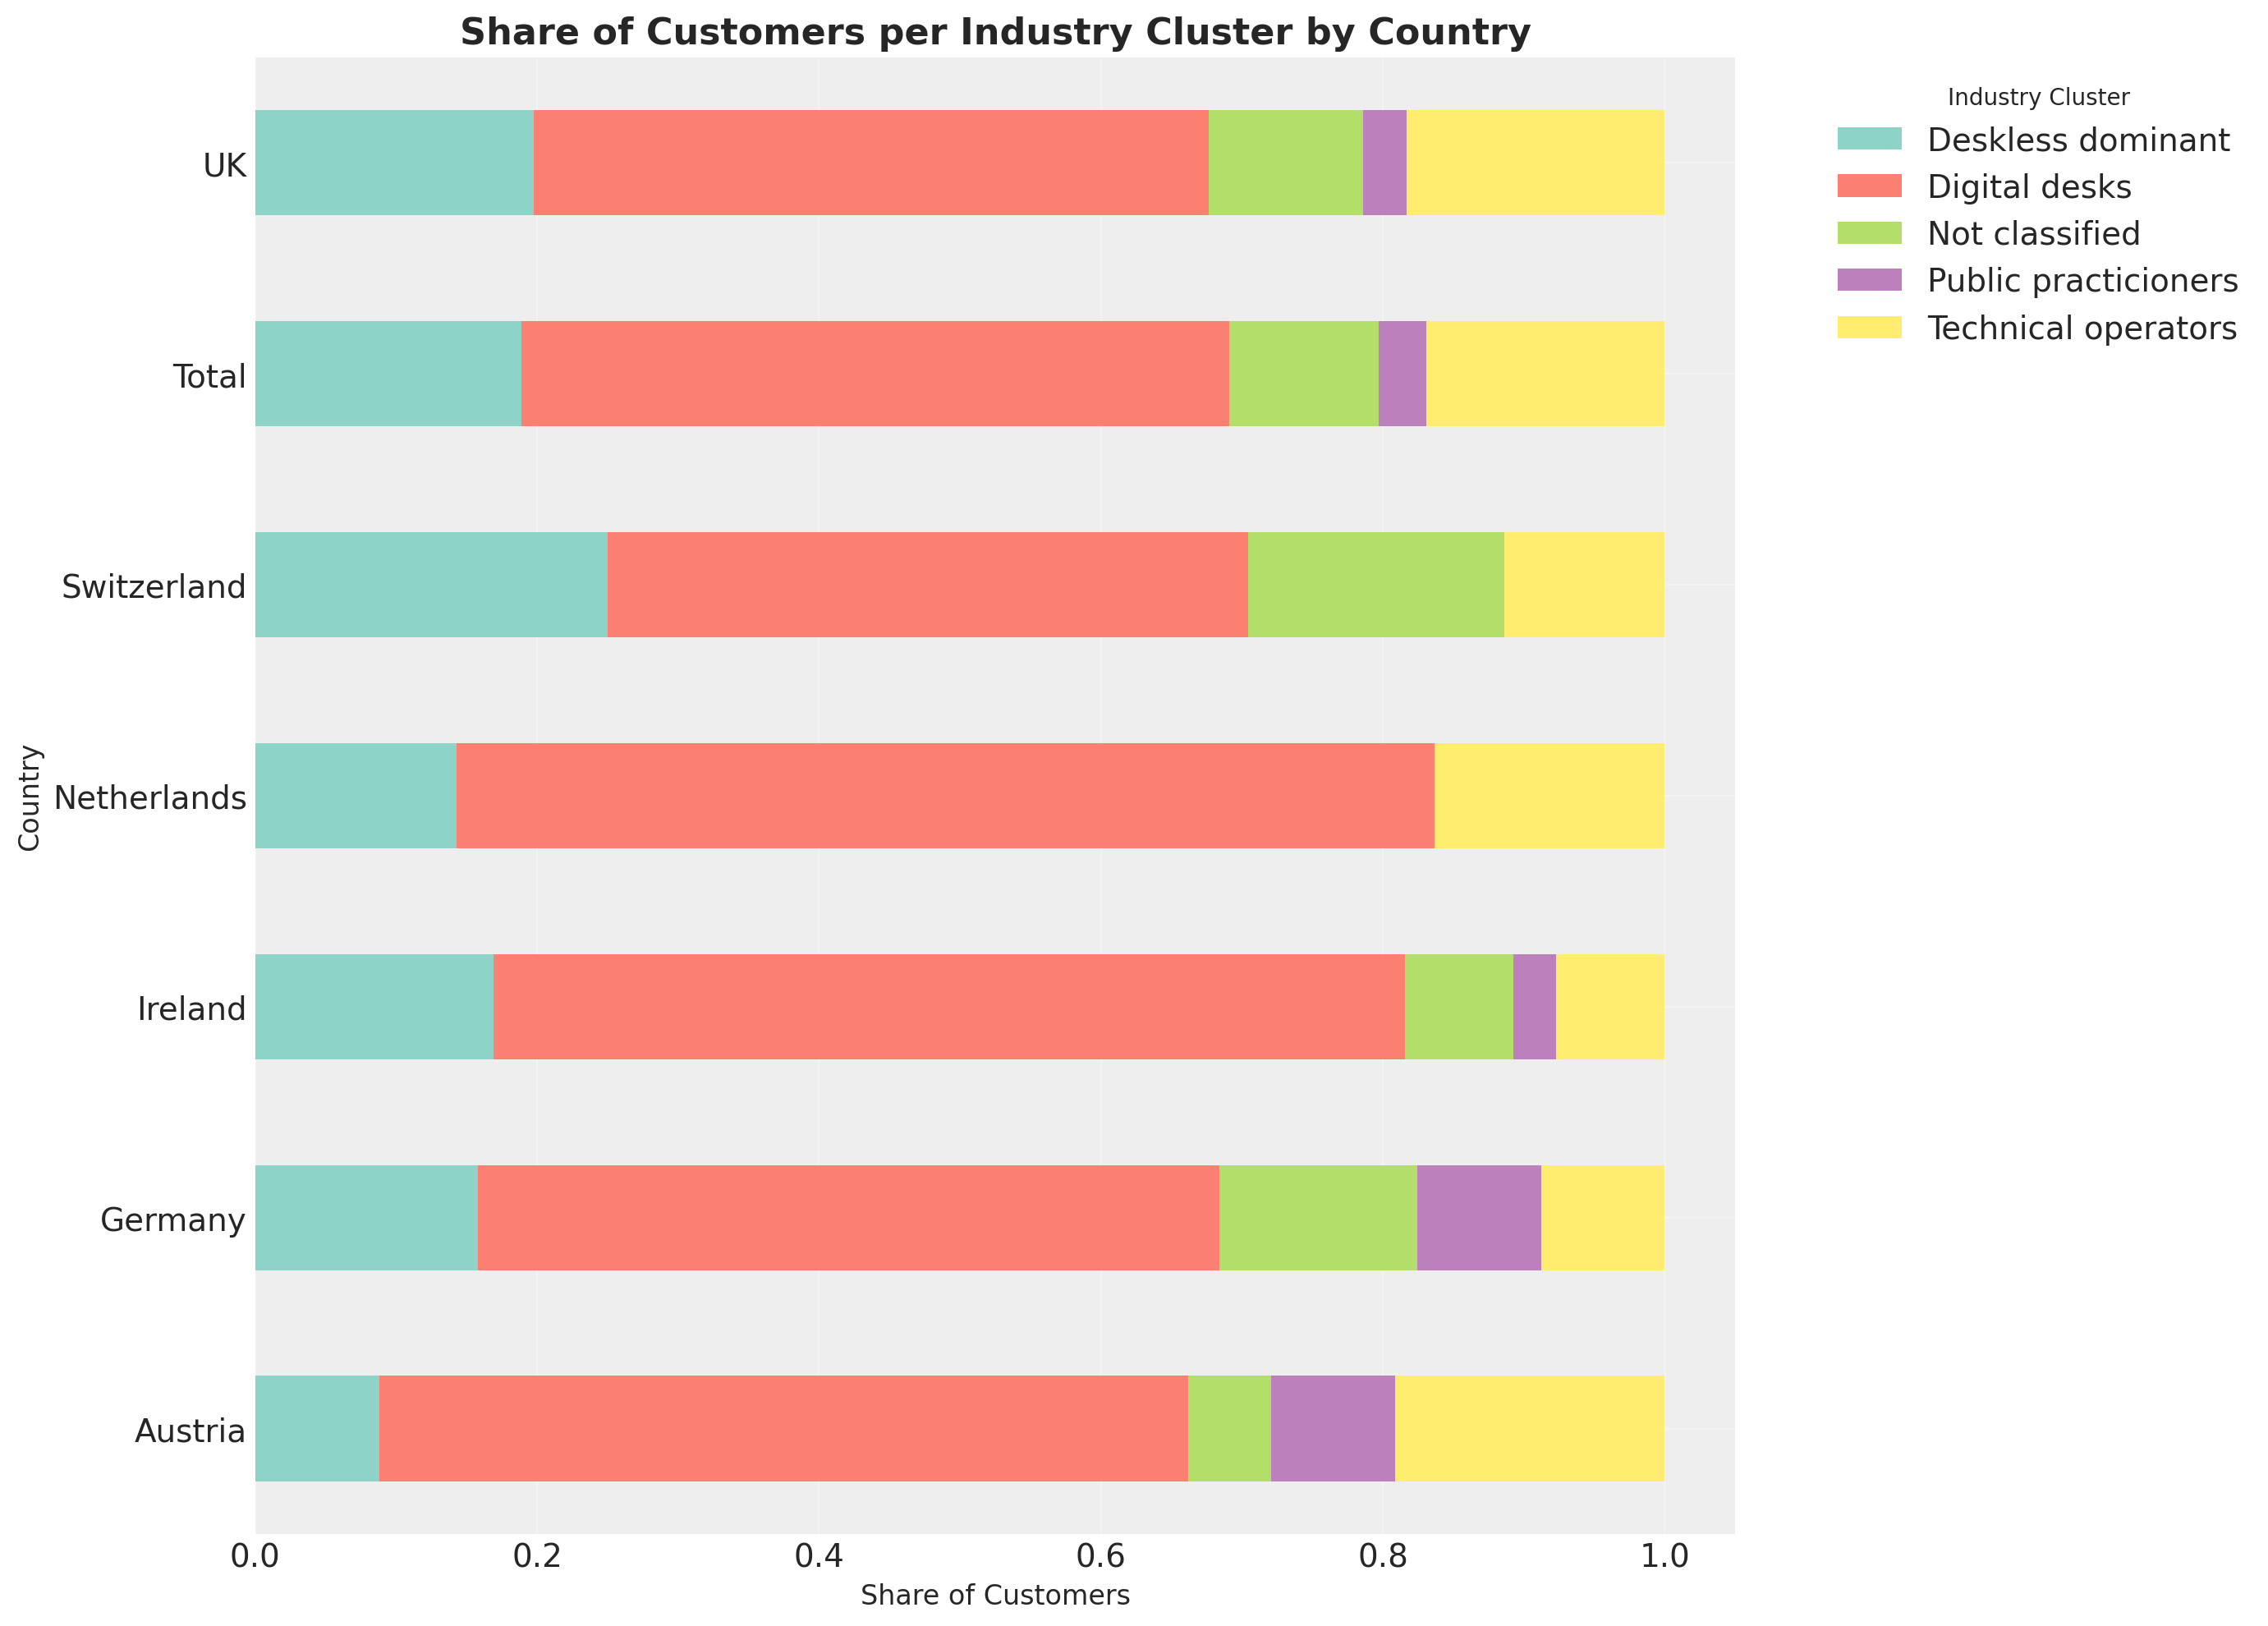

Share of Customers per Industry Cluster by Country:
INDUSTRY_CLUSTER  Deskless dominant  Digital desks  Not classified  \
COUNTRY                                                              
Austria                       0.088          0.574           0.059   
Germany                       0.158          0.526           0.140   
Ireland                       0.169          0.646           0.077   
Netherlands                   0.143          0.694           0.000   
Switzerland                   0.250          0.455           0.182   
Total                         0.189          0.502           0.106   
UK                            0.198          0.479           0.110   

INDUSTRY_CLUSTER  Public practicioners  Technical operators  
COUNTRY                                                      
Austria                          0.088                0.191  
Germany                          0.088                0.088  
Ireland                          0.031                0.077  
Netherl

In [ ]:
# Calculate the share of customers per INDUSTRY_CLUSTER grouped by COUNTRY
industry_share = (
    customers_filtered.groupby("COUNTRY")["INDUSTRY_CLUSTER"]
    .value_counts(normalize=True)
    .reset_index()
)
industry_share.columns = ["COUNTRY", "INDUSTRY_CLUSTER", "SHARE"]

# Calculate the total distribution from the full customers dataset
total_distribution = (
    customers["INDUSTRY_CLUSTER"].value_counts(normalize=True).reset_index()
)
total_distribution.columns = ["INDUSTRY_CLUSTER", "SHARE"]
total_distribution["COUNTRY"] = "Total"

# Combine the country-specific and total distributions
combined_share = pd.concat([industry_share, total_distribution], ignore_index=True)

# Create a pivot table with countries as index and industry clusters as columns
industry_pivot = combined_share.pivot(
    index="COUNTRY", columns="INDUSTRY_CLUSTER", values="SHARE"
).fillna(0)

# Create a stacked bar chart showing countries on x-axis and industry clusters as colors
plt.figure(figsize=(14, 10))
industry_pivot.plot(kind="barh", stacked=True, figsize=(14, 10), colormap="Set3")
plt.title(
    "Share of Customers per Industry Cluster by Country", fontsize=16, fontweight="bold"
)
plt.xlabel("Share of Customers", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.legend(title="Industry Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display the data table
print("Share of Customers per Industry Cluster by Country:")
print("=" * 60)
print(industry_pivot.round(3))


/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_2048/1199192864.py:34: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1400x1000 with 0 Axes>

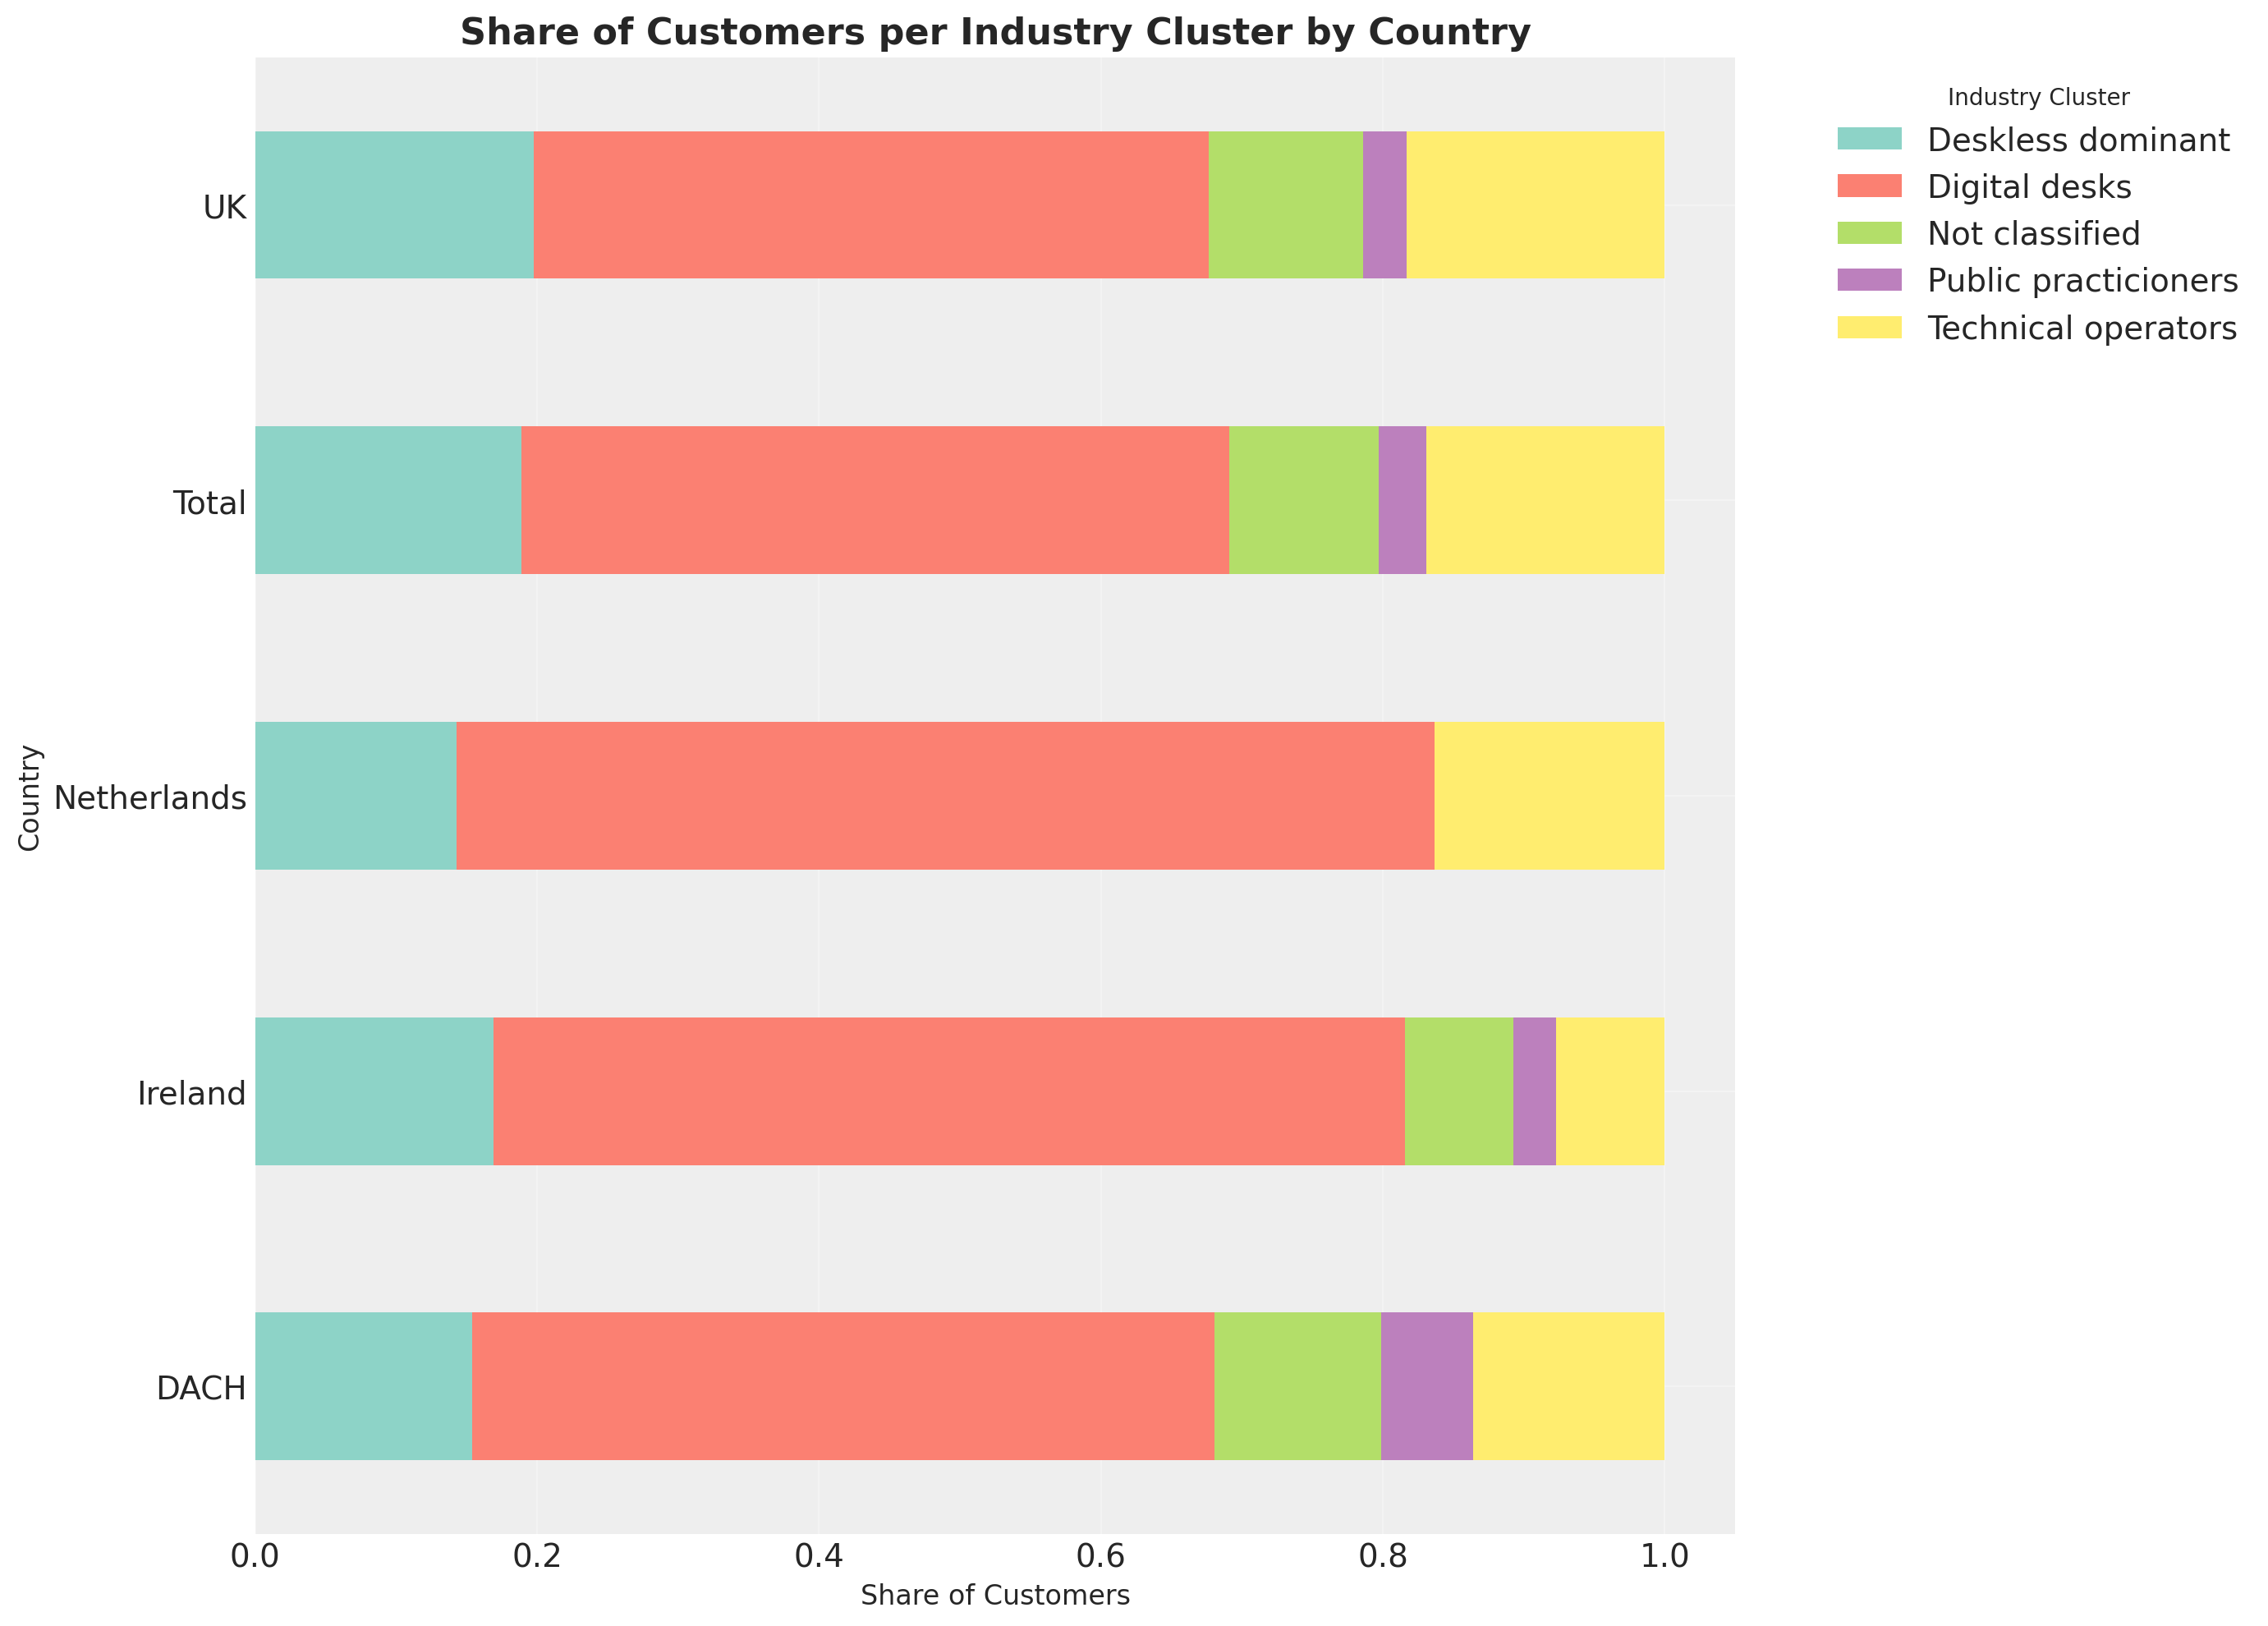

Share of Customers per Industry Cluster by Country:
INDUSTRY_CLUSTER  Deskless dominant  Digital desks  Not classified  \
COUNTRY_GROUP                                                        
DACH                          0.154          0.527           0.118   
Ireland                       0.169          0.646           0.077   
Netherlands                   0.143          0.694           0.000   
Total                         0.189          0.502           0.106   
UK                            0.198          0.479           0.110   

INDUSTRY_CLUSTER  Public practicioners  Technical operators  
COUNTRY_GROUP                                                
DACH                             0.065                0.136  
Ireland                          0.031                0.077  
Netherlands                      0.000                0.163  
Total                            0.034                0.169  
UK                               0.031                0.183  


In [167]:
# Calculate the share of customers per INDUSTRY_CLUSTER grouped by COUNTRY
industry_share = (
    customers_filtered.groupby("COUNTRY_GROUP")["INDUSTRY_CLUSTER"]
    .value_counts(normalize=True)
    .reset_index()
)
industry_share.columns = ["COUNTRY_GROUP", "INDUSTRY_CLUSTER", "SHARE"]

# Calculate the total distribution from the full customers dataset
total_distribution = (
    customers["INDUSTRY_CLUSTER"].value_counts(normalize=True).reset_index()
)
total_distribution.columns = ["INDUSTRY_CLUSTER", "SHARE"]
total_distribution["COUNTRY_GROUP"] = "Total"

# Combine the country-specific and total distributions
combined_share = pd.concat([industry_share, total_distribution], ignore_index=True)

# Create a pivot table with countries as index and industry clusters as columns
industry_pivot = combined_share.pivot(
    index="COUNTRY_GROUP", columns="INDUSTRY_CLUSTER", values="SHARE"
).fillna(0)

# Create a stacked bar chart showing countries on x-axis and industry clusters as colors
plt.figure(figsize=(14, 10))
industry_pivot.plot(kind="barh", stacked=True, figsize=(14, 10), colormap="Set3")
plt.title(
    "Share of Customers per Industry Cluster by Country", fontsize=16, fontweight="bold"
)
plt.xlabel("Share of Customers", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.legend(title="Industry Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Display the data table
print("Share of Customers per Industry Cluster by Country:")
print("=" * 60)
print(industry_pivot.round(3))
